In [28]:
from env.dis_one_joint import ArmEnv
import matplotlib
import torch
from matplotlib import pyplot as plt
import numpy as np

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
BATCH_SIZE = 64
GAMMA = 0.9
EPS_START = 0.5
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-2
Hidden_size = 64

In [30]:
EP_LEN = 50
env = ArmEnv(ep_len=EP_LEN, scale=True)
obs_dim = len(env.observation_space)
action_dim = env.action_dim
print("obs_dim: %d" %obs_dim, "action_dim: %d" %action_dim)


obs_dim: 2 action_dim: 2


Create Q_net work and Q target net work

In [31]:
from utils.DQN import ReplayMemory, DQN, DQN_Agent

Q_net = DQN(obs_dim, action_dim, Hidden_size).to(device)
Q_target_net = DQN(obs_dim, action_dim, Hidden_size).to(device)
memory = ReplayMemory(int(1e4))

Agent = DQN_Agent(env=env, buffer=memory, Q_net=Q_net, Q_target_net=Q_target_net,
                  batch_size=BATCH_SIZE, gamma=GAMMA, EPS_START=EPS_START,
                  EPS_END=EPS_END, EPS_DECAY=EPS_DECAY, TAU=0.05, LR=LR, device=device)

In [32]:
def plot_data(reward, show_result=False, ylabel="reward"):
    plt.figure(1)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel(ylabel)
    plt.plot(reward)

    if len(reward) >= 50:
        means = np.convolve(reward, np.ones(50), 'valid') / 50
        means = np.concatenate((np.zeros(50), means))
        plt.plot(means)

    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)

        else:
            display.display(plt.gcf())

Complete


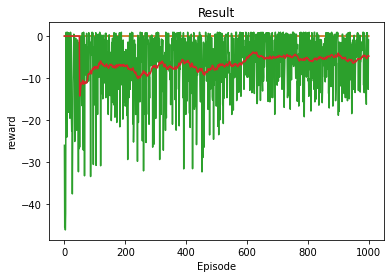

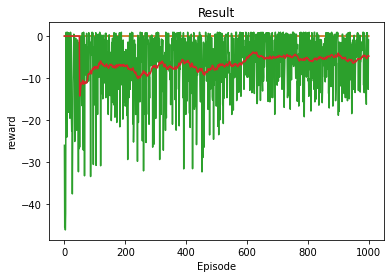

In [33]:
if torch.cuda.is_available():
    num_episodes = 1000
else:
    num_episodes = 50

episode_reward = []
loss_list = []
for i_episode in range(num_episodes):
    cum_reward = 0
    cum_loss = 0
    done = False
    steps = 0
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    while not done:
        steps += 1
        action = Agent.select_action(state)
        observation, reward, done, terminated = env.step(action.item())
        cum_reward += reward
        reward = torch.tensor([reward], dtype=torch.float32, device=device)

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        memory.push(state, action, next_state, reward)
        state = next_state

        loss = Agent.optimize_model()
        cum_loss += loss

        Agent.update_target_net()

    loss_list.append(cum_loss/steps)
    episode_reward.append(cum_reward)
    #plot_data(episode_reward)
    plot_data(loss_list)

print('Complete')
plot_data(episode_reward,show_result=True)
plt.ioff()
plt.show()

Complete


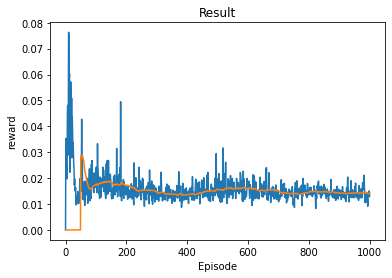

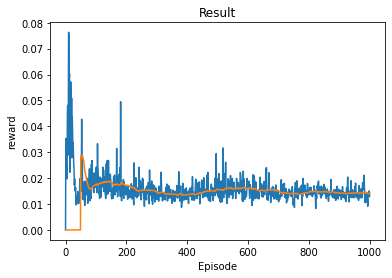

In [34]:
print('Complete')
plot_data(loss_list,show_result=True)
plt.ioff()
plt.show()

In [16]:
for i_episode in range(10):
    done = False
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    while not done:
        action = Agent.select_action(state)
        observation, reward, done, terminated = env.step(action.item())
        env.render()


In [36]:
Agent.save()

Saving buffer to checkpoints/dqn/model.pt


In [37]:
path = "./checkpoints/dqn/model.pt"
new_Q_net = DQN(obs_dim, action_dim, Hidden_size).to(device)
new_Q_net.load_state_dict(torch.load(path))
new_Q_net.eval()

DQN(
  (layer1): Linear(in_features=2, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=2, bias=True)
)

In [38]:
# DQN_table
obs_dim_shape= env.observation_space
DQN_table = np.zeros((obs_dim_shape + [action_dim]))
print(DQN_table.shape)

# get batch of state
for i in range(obs_dim_shape[0]):
    for j in range(obs_dim_shape[1]):
        state = np.array((i, j)) / env.space_length
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        with torch.no_grad():
            value = new_Q_net(state)[0]
            DQN_table[i,j,:] = value.detach().cpu().numpy()


(50, 50, 2)


Text(0, 0.5, 'point_angle')

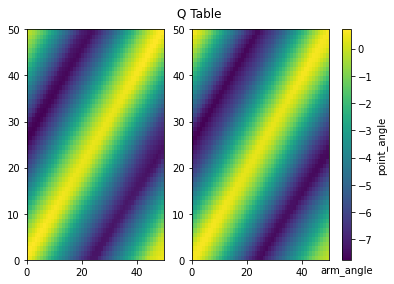

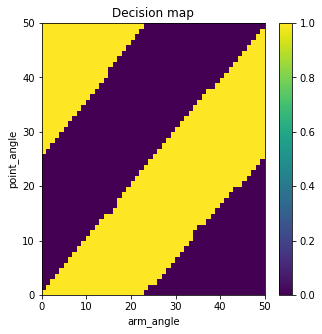

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Q Table')
im1 = ax1.pcolormesh(DQN_table[:, :, 0])
im2 = ax2.pcolormesh(DQN_table[:, :, 1])

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.02)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im1, cax=cb_ax)

plt.xlabel('arm_angle')
plt.ylabel('point_angle')

fig = plt.figure(figsize=(5, 5))
plt.title('Decision map')
max_decision = np.argmax(DQN_table, axis=2)
im = plt.pcolormesh(max_decision)
cbar = fig.colorbar(im)
plt.xlabel('arm_angle')
plt.ylabel('point_angle')